# Autotrader_3_linreg
---

In [1]:
# import packages (pd, viz)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# import myfunctions.py (functions used in multiple notebooks)
import myfunctions

# import packages (preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# import packages (models)
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Read in file

In [2]:
# Read in file

filepath = '../data/df_master_2.csv'
df = pd.read_csv(filepath, index_col=0)

print(df.shape)
df.head()

(14996, 13)


,year,body,mileage,engine_size,horsepower,transmission,fuel,ulez,seller_type,price,make,model,bhp_per_litre
0,2008.0,estate,115000.0,2.0,168.0,manual,diesel,0,trade_seller,3995,audi,a4,84.000000
1,2011.0,hatchback,112988.0,1.6,104.0,automatic,diesel,0,trade_seller,4799,audi,a3,65.000000
2,2011.0,suv,96000.0,2.0,168.0,manual,petrol,1,trade_seller,8740,audi,q3,84.000000
3,2015.0,saloon,97837.0,2.0,190.0,automatic,diesel,1,trade_seller,10900,audi,a6,95.000000
4,2009.0,coupe,67345.0,1.8,168.0,manual,petrol,1,trade_seller,6491,audi,a5,93.333333


### Multicollinearity - Variance Inflation Factor

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

features_cont = ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
features_cat = [i for i in df.columns if i not in features_cont]
# features_cat.remove('price') # remove target variable

X = df[features_cont]

calc_vif(X)

,variables,VIF
0,year,96.720549
1,mileage,3.122820
2,engine_size,93.855363
3,horsepower,86.446800
4,bhp_per_litre,88.072361


# Define Functions
1. pipe_construct: construct a pipeline according to input features and choice of model
2. plot_coef_pipe: function to plot resulting coefficients from fitted pipe

In [4]:
def pipe_construct(features_cont=features_cont, features_cat=features_cat, model=LinearRegression()):
    '''
    Input: continuous features, categorical features, model of choice. 
    Returns: pipeline.
    '''
    t = [('cont', StandardScaler(), features_cont), 
         ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), features_cat)]

    transformer = ColumnTransformer(transformers=t, remainder='drop')

    pipe = Pipeline(steps=[('transformer', transformer), ('model', model)])
    return pipe


def plot_coef_pipe(pipe, X_train, X_test, y_train, y_test):
    '''plot coefficients from a model'''
    # df for model coefficients    
#     col_names = features_cont + list(transformer.named_transformers_.cat.get_feature_names())
    col_names = features_cont + list(pipe.named_steps.transformer.named_transformers_.cat.get_feature_names())
    
    df_model_coef = pd.DataFrame(pipe.named_steps.model.coef_, index=col_names, columns=['coef'])
    df_model_coef['coef_abs'] = np.abs(df_model_coef)
    
    # plot coefficients in order of importance
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.tight_layout(w_pad=10)

    df_model_coef.coef.sort_values()[:10].plot(kind='barh', ax=ax[0])
    df_model_coef.coef.sort_values()[-10:].plot(kind='barh', ax=ax[1])

    ax[0].set_title('Feature Importance (negative impact)')
    ax[1].set_title('Feature Importance (positive impact)')

    print('Coefficients:')
    plt.show()

In [5]:
# Set features and target
X = df.copy()
y = X.pop('price')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11996, 12), (3000, 12), (11996,), (3000,))

In [6]:
# Define input features 
features_cont = ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
features_cat = [i for i in df.columns if i not in features_cont]
features_cat.remove('price') # remove target variable
# features_cat.remove('body')
# features_cat.remove('model')

features_cat

['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']

# 1. Linear Regression - no regularisation

In [7]:
# LinearRegression(); all features
features_cont = ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
features_cat = ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']
# features_cat = [i for i in df.columns if i not in features_cont]
# features_cat.remove('price') # remove target variable
# features_cat.remove('body')
# features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, LinearRegression())
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
cat features:   ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']

LinearRegression()

R2 Train, Test:		0.8621390243921754 	 -1.8010667305570317e+17
R2 Train (CV Mean):	-4.853569546396363e+17

RMSE Train, Test:	11061.525609722943 	 12230361789124.908
MAE  Train, Test:	3862.555570606869 	 288453415189.0343


In [8]:
# LinearRegression(); all features
features_cont = ['year', 'mileage', 'engine_size', 'horsepower']
features_cat = ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']
# features_cat = [i for i in df.columns if i not in features_cont]
# features_cat.remove('price') # remove target variable
# features_cat.remove('body')
# features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, LinearRegression())
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'engine_size', 'horsepower']
cat features:   ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']

LinearRegression()

R2 Train, Test:		0.8486636483114051 	 -1.0055842697702208e+18
R2 Train (CV Mean):	-4.003038878660545e+17

RMSE Train, Test:	11589.53430734459 	 28899054748089.13
MAE  Train, Test:	4054.714008836279 	 1045628869927.9033


In [9]:
# LinearRegression(); all features_cont, remove body and model from features_cat
features_cont = ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
features_cat = ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']
# features_cat.remove('price') # remove target variable
features_cat.remove('body')
features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, LinearRegression())
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# # plots
# myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
# myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
# plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
cat features:   ['transmission', 'fuel', 'ulez', 'seller_type', 'make']

LinearRegression()

R2 Train, Test:		0.8072997882832932 	 0.8090213811123044
R2 Train (CV Mean):	-42305026795446.35

RMSE Train, Test:	13077.822882894874 	 12594.089530675357
MAE  Train, Test:	5160.328859619874 	 5108.019333333334



In [10]:
# LinearRegression(); all features_cont, remove body and model from features_cat
features_cont = ['year', 'mileage', 'engine_size', 'horsepower']
features_cat = [i for i in df.columns if i not in features_cont]
features_cat.remove('price') # remove target variable
features_cat.remove('body')
features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, LinearRegression())
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# # plots
# myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
# myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
# plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'engine_size', 'horsepower']
cat features:   ['transmission', 'fuel', 'ulez', 'seller_type', 'make', 'bhp_per_litre']

LinearRegression()

R2 Train, Test:		0.9406142492028967 	 -7.0576391555399704e+16
R2 Train (CV Mean):	-6.1829174563025384e+16

RMSE Train, Test:	7259.980950035725 	 7656038824935.877
MAE  Train, Test:	2789.11162054018 	 947901200511.3914



cont features:  ['year', 'mileage', 'engine_size', 'horsepower']
cat features:   []

LinearRegression()

R2 Train, Test:		0.6904309978279761 	 0.700727877217421
R2 Train (CV Mean):	0.6856168784833325

RMSE Train, Test:	16575.746224105038 	 15765.492210105498
MAE  Train, Test:	7790.7724631829 	 7628.312460000021

Predictions:


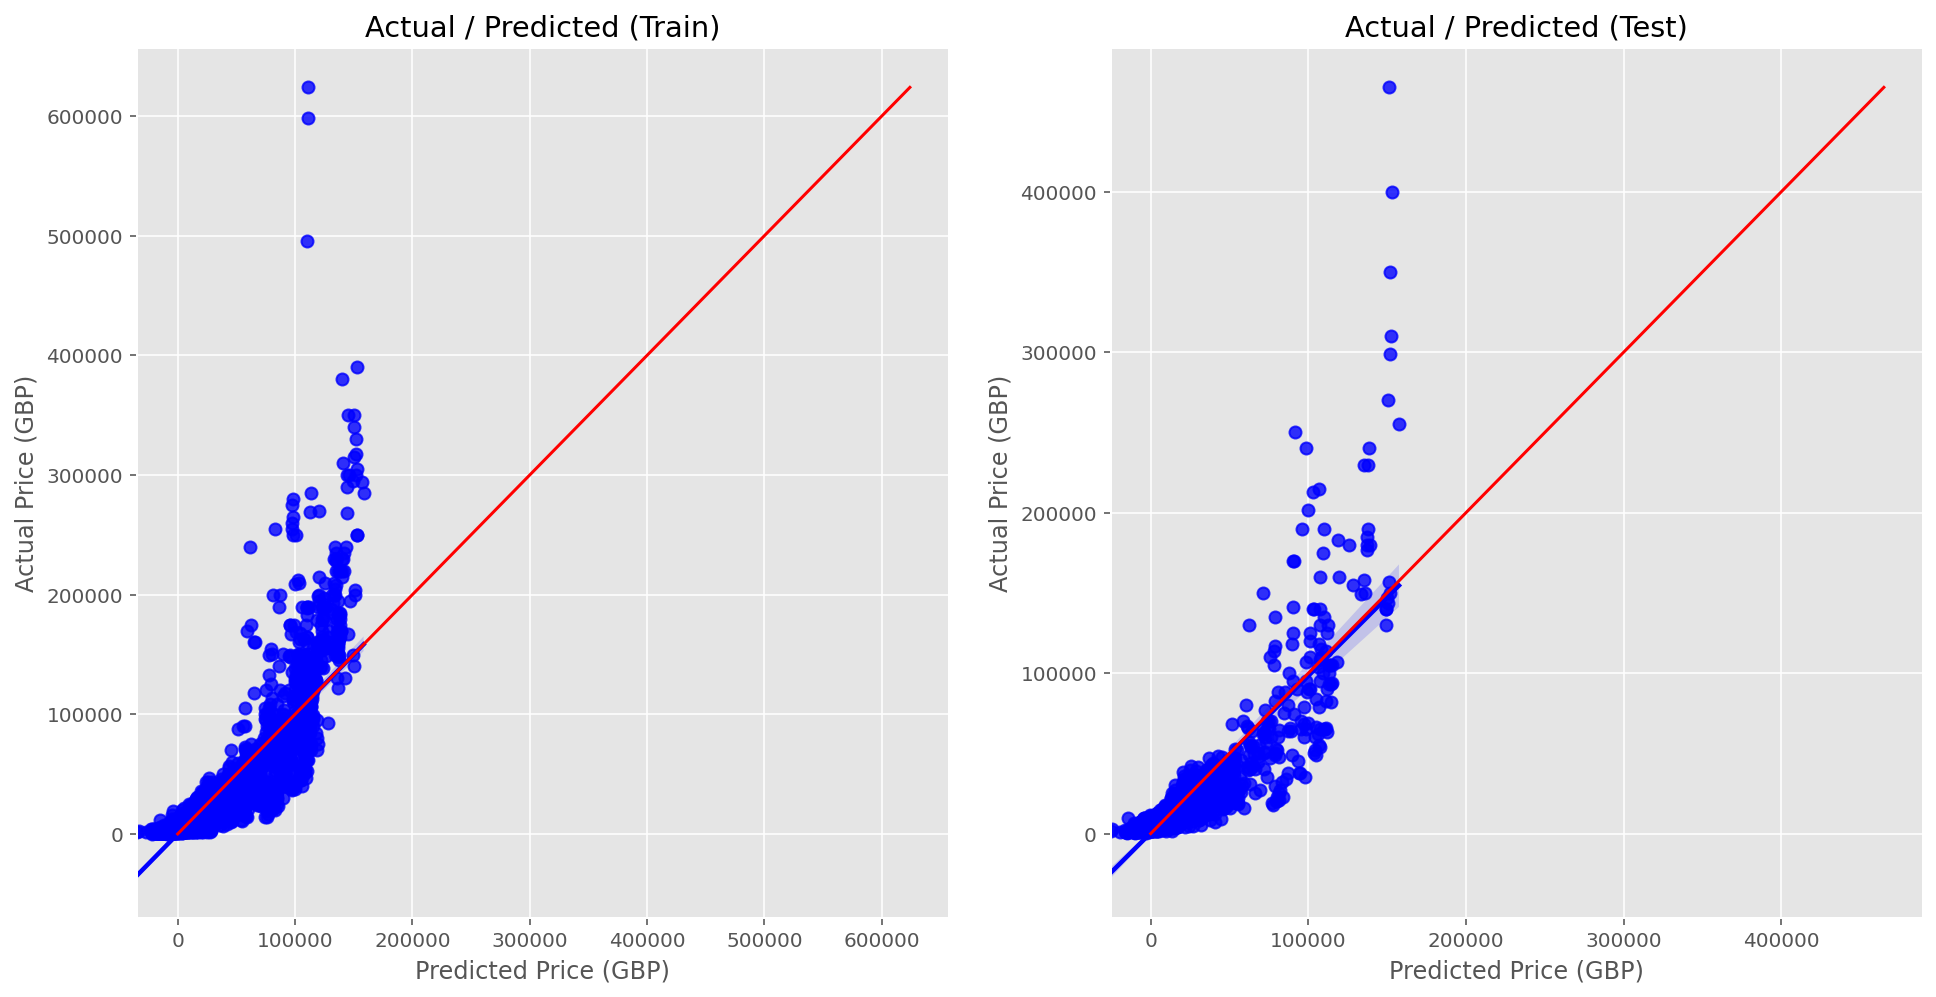

Distribution of residuals:


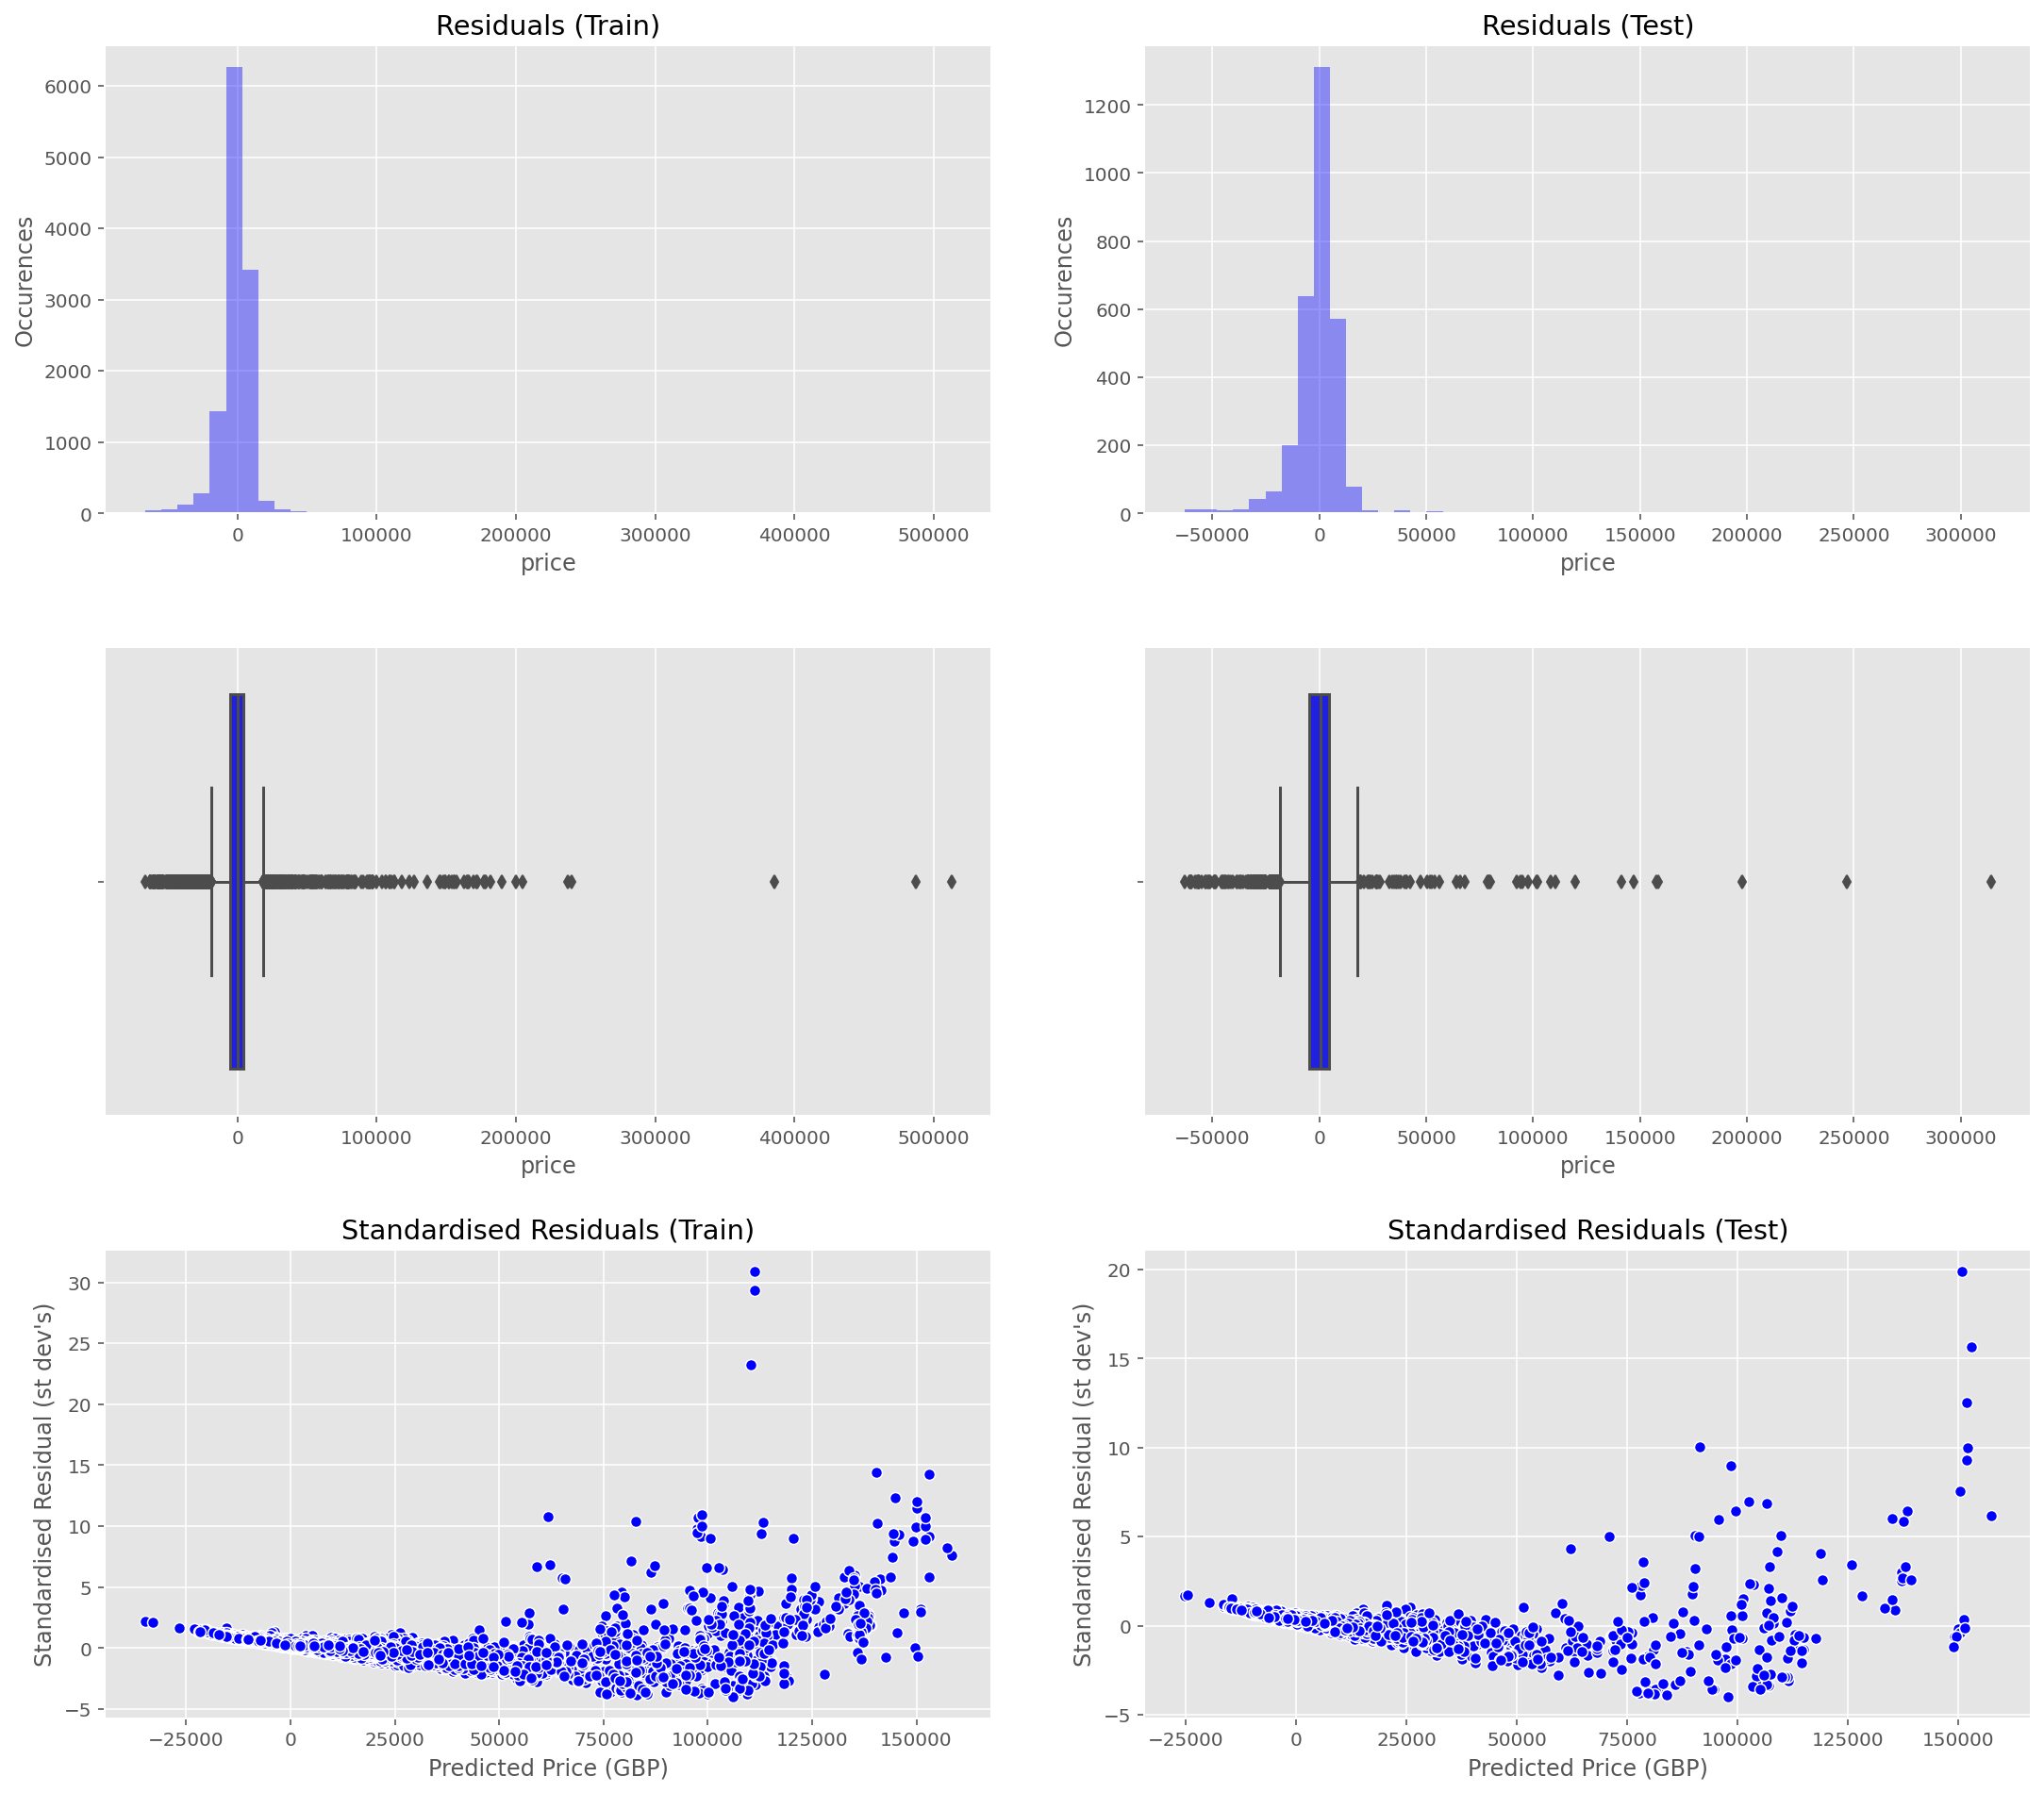

In [11]:
# LinearRegression(); only features_cont, no categorical
features_cont = ['year', 'mileage', 'engine_size', 'horsepower']
features_cat = []
# features_cat.remove('price') # remove target variable
# features_cat.remove('body')
# features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, LinearRegression())
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# plots
myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)

# Ridge Regression

In [12]:
# RidgeCV(); all features_cont, remove body and model from features_cat
features_cont = ['year', 'mileage', 'bhp_per_litre']
features_cat = ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']
# features_cat.remove('price') # remove target variable
features_cat.remove('body')
features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, RidgeCV(np.logspace(-4,4,10), cv=5))
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# # plots
# myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
# myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
# plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'bhp_per_litre']
cat features:   ['transmission', 'fuel', 'ulez', 'seller_type', 'make']

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

R2 Train, Test:		0.752848013400939 	 0.7638435679896927
R2 Train (CV Mean):	0.7433053196619472

RMSE Train, Test:	14810.728069444229 	 14004.715524951094
MAE  Train, Test:	5731.222852759138 	 5638.271354544721



In [13]:
# RidgeCV(); all features_cont, remove body and model from features_cat
features_cont = ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
features_cat = ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']
# features_cat.remove('price') # remove target variable
features_cat.remove('body')
features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, RidgeCV(np.logspace(-4,4,10), cv=5))
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# # plots
# myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
# myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
# plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
cat features:   ['transmission', 'fuel', 'ulez', 'seller_type', 'make']

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

R2 Train, Test:		0.8072816929197628 	 0.8089147583861513
R2 Train (CV Mean):	0.7996630694040382

RMSE Train, Test:	13078.436899874523 	 12597.604659219194
MAE  Train, Test:	5169.534422606767 	 5119.055900135378



In [14]:
# RidgeCV(); all features_cont, remove body and model from features_cat
features_cont = ['year', 'mileage', 'engine_size', 'horsepower']
features_cat = [i for i in df.columns if i not in features_cont]
features_cat.remove('price') # remove target variable
features_cat.remove('body')
features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, RidgeCV(np.logspace(-4,4,10), cv=5))
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# # plots
# myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
# myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
# plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)

cont features:  ['year', 'mileage', 'engine_size', 'horsepower']
cat features:   ['transmission', 'fuel', 'ulez', 'seller_type', 'make', 'bhp_per_litre']

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

R2 Train, Test:		0.9386551219859042 	 0.8745336778741646
R2 Train (CV Mean):	0.9020810520853966

RMSE Train, Test:	7378.762109626922 	 10207.937114049575
MAE  Train, Test:	2906.241922530482 	 3402.8928189281587



cont features:  ['year', 'mileage', 'engine_size', 'horsepower']
cat features:   ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model', 'bhp_per_litre']

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

R2 Train, Test:		0.9569635409970798 	 0.8963358055952783
R2 Train (CV Mean):	0.9218923133271092

RMSE Train, Test:	6180.343602146363 	 9278.73541116603
MAE  Train, Test:	2289.5071213500946 	 2888.615590404446

Predictions:


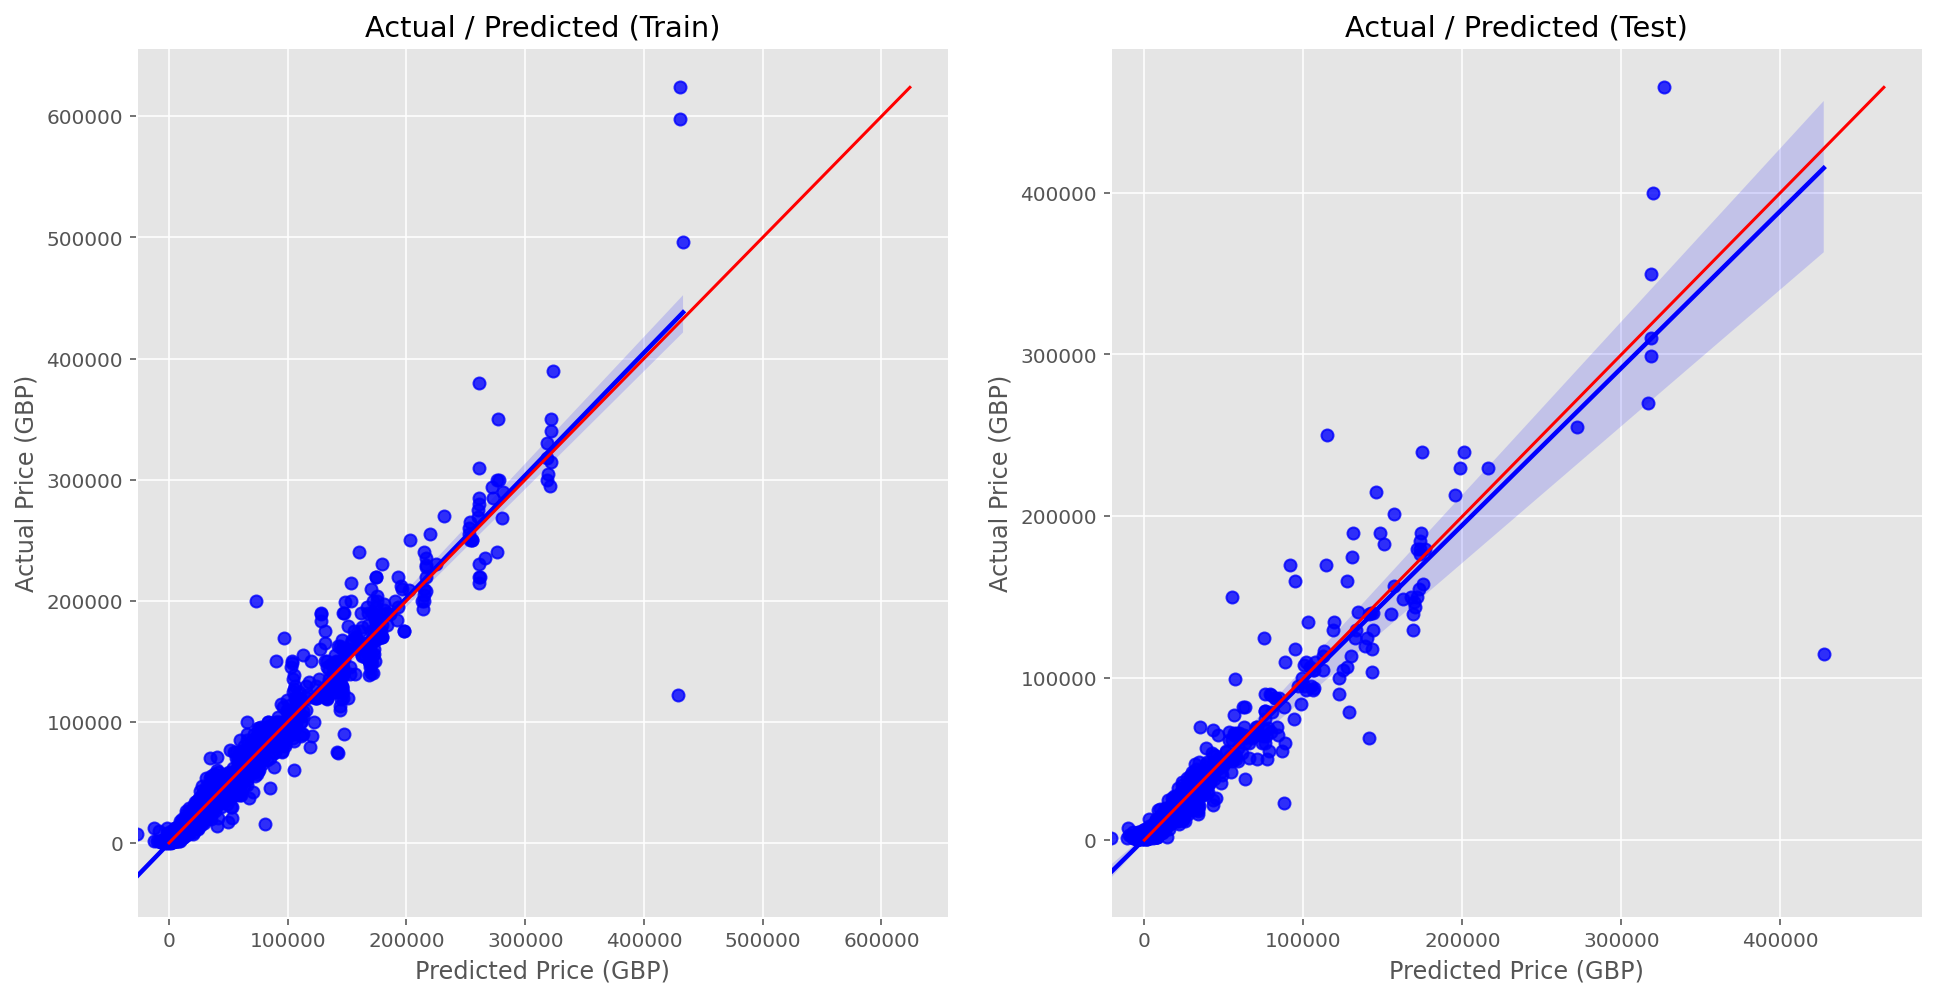

Distribution of residuals:


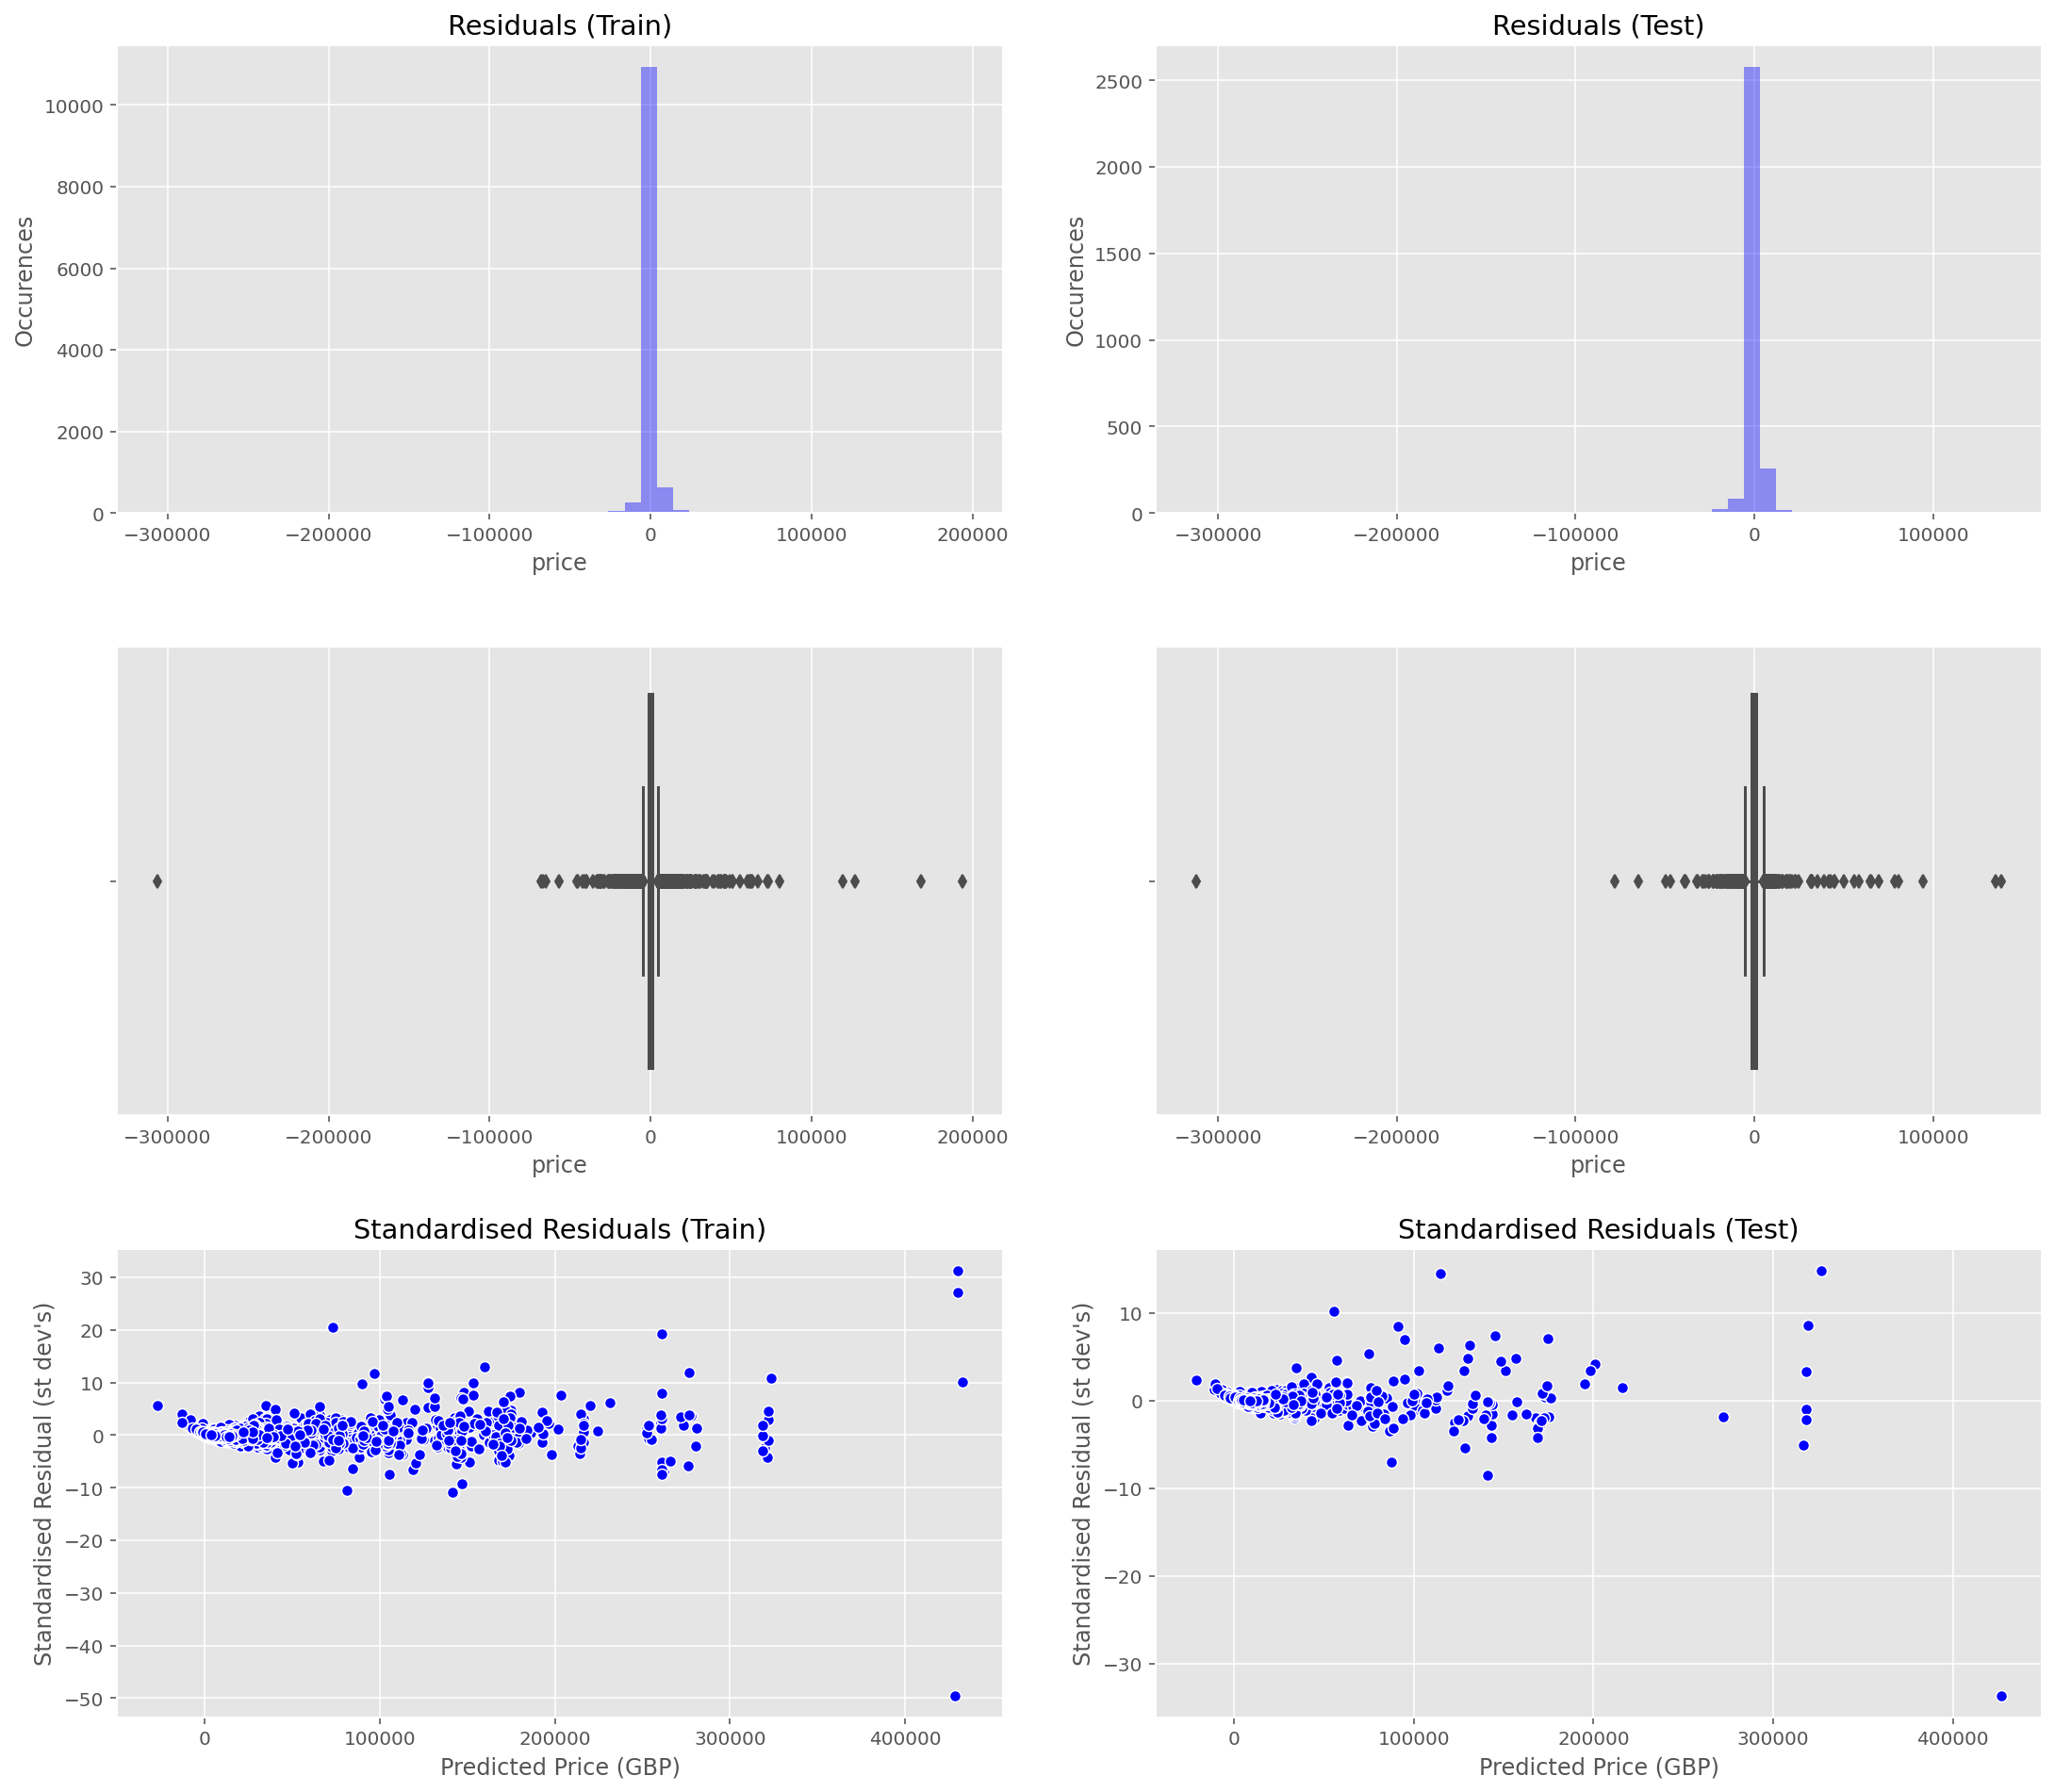

Coefficients:


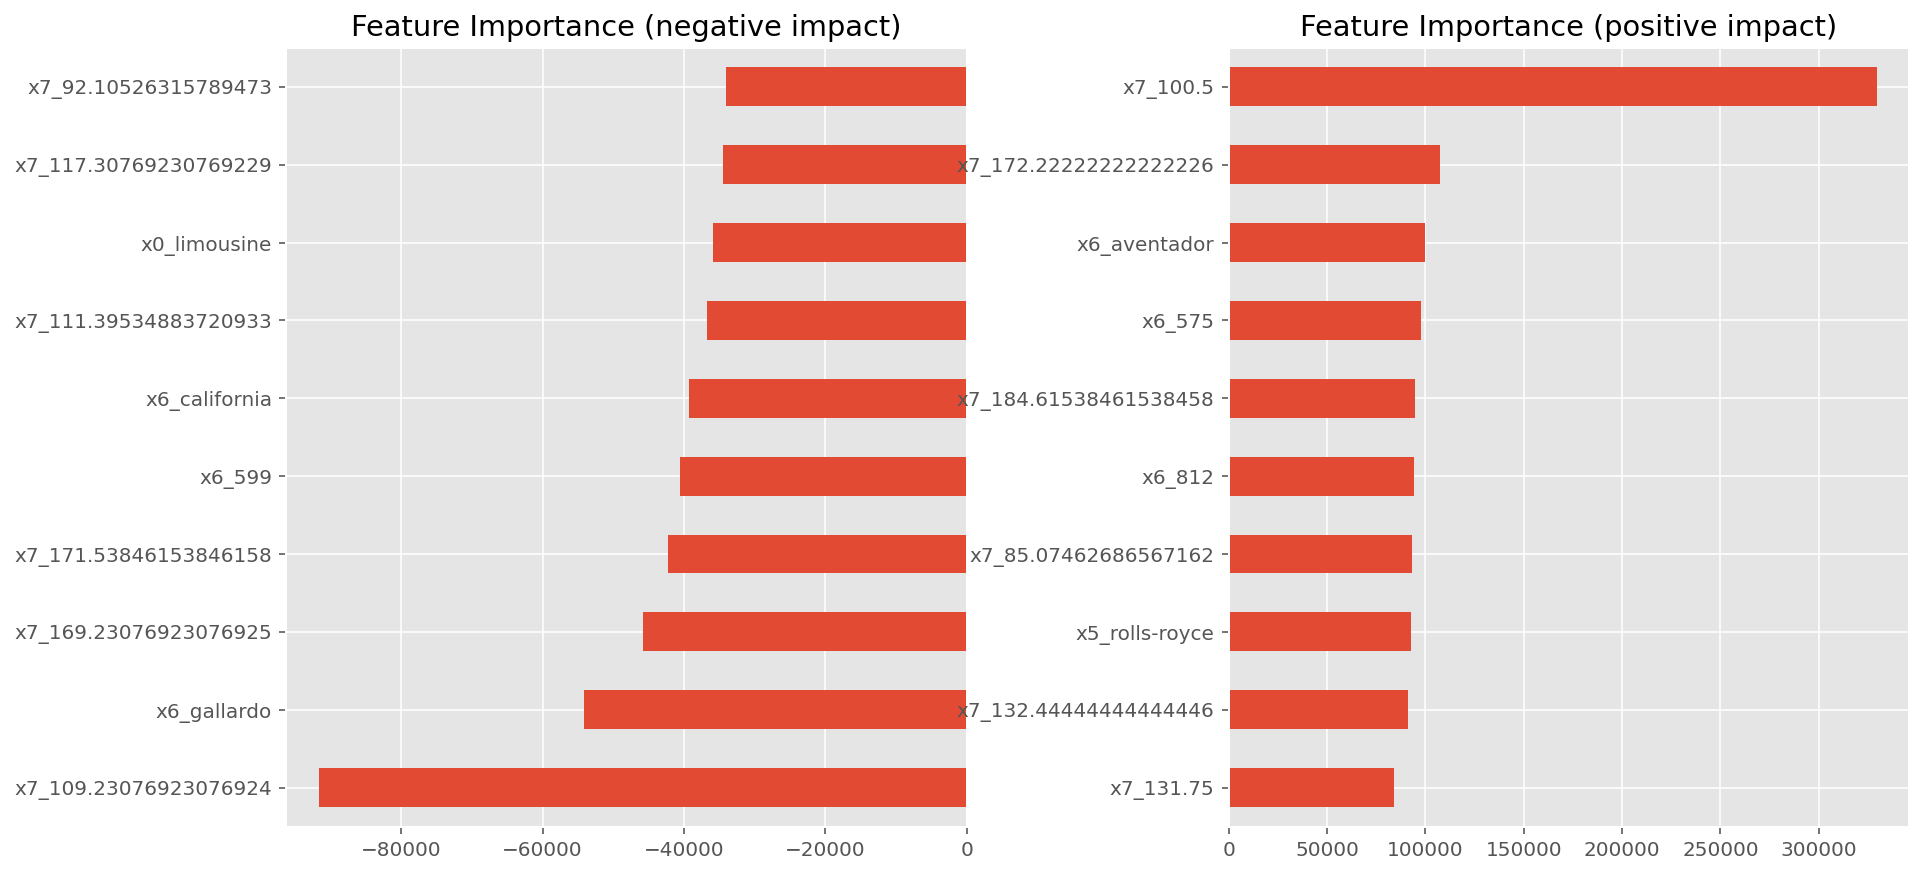

In [12]:
# RidgeCV(); all features
features_cont = ['year', 'mileage', 'engine_size', 'horsepower']
features_cat = [i for i in df.columns if i not in features_cont]
features_cat.remove('price') # remove target variable
# features_cat.remove('body')
# features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, RidgeCV(np.logspace(-4,4,10), cv=5))
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# plots
myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)

In [14]:
pipe.named_steps.model

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

In [15]:
pipe.named_steps.model.alpha_

0.3593813663804626

# Lasso Regression

cont features:  ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
cat features:   ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']



/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2180152546.0390625, tolerance: 839290539.8362287
  model = cd_fast.enet_coordinate_descent_gram(
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1737746850.2331543, tolerance: 816538411.4431287
  model = cd_fast.enet_coordinate_descent_gram(
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011415165.0837402, tolerance: 887167901.3998212
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5, max_iter=100000, n_jobs=-1, random_state=1)

R2 Train, Test:		0.8618331729105858 	 0.867470939926312
R2 Train (CV Mean):	0.8451646601178504

RMSE Train, Test:	11073.789086095692 	 10491.315828326202
MAE  Train, Test:	3890.421361411319 	 4161.170701606258

Predictions:


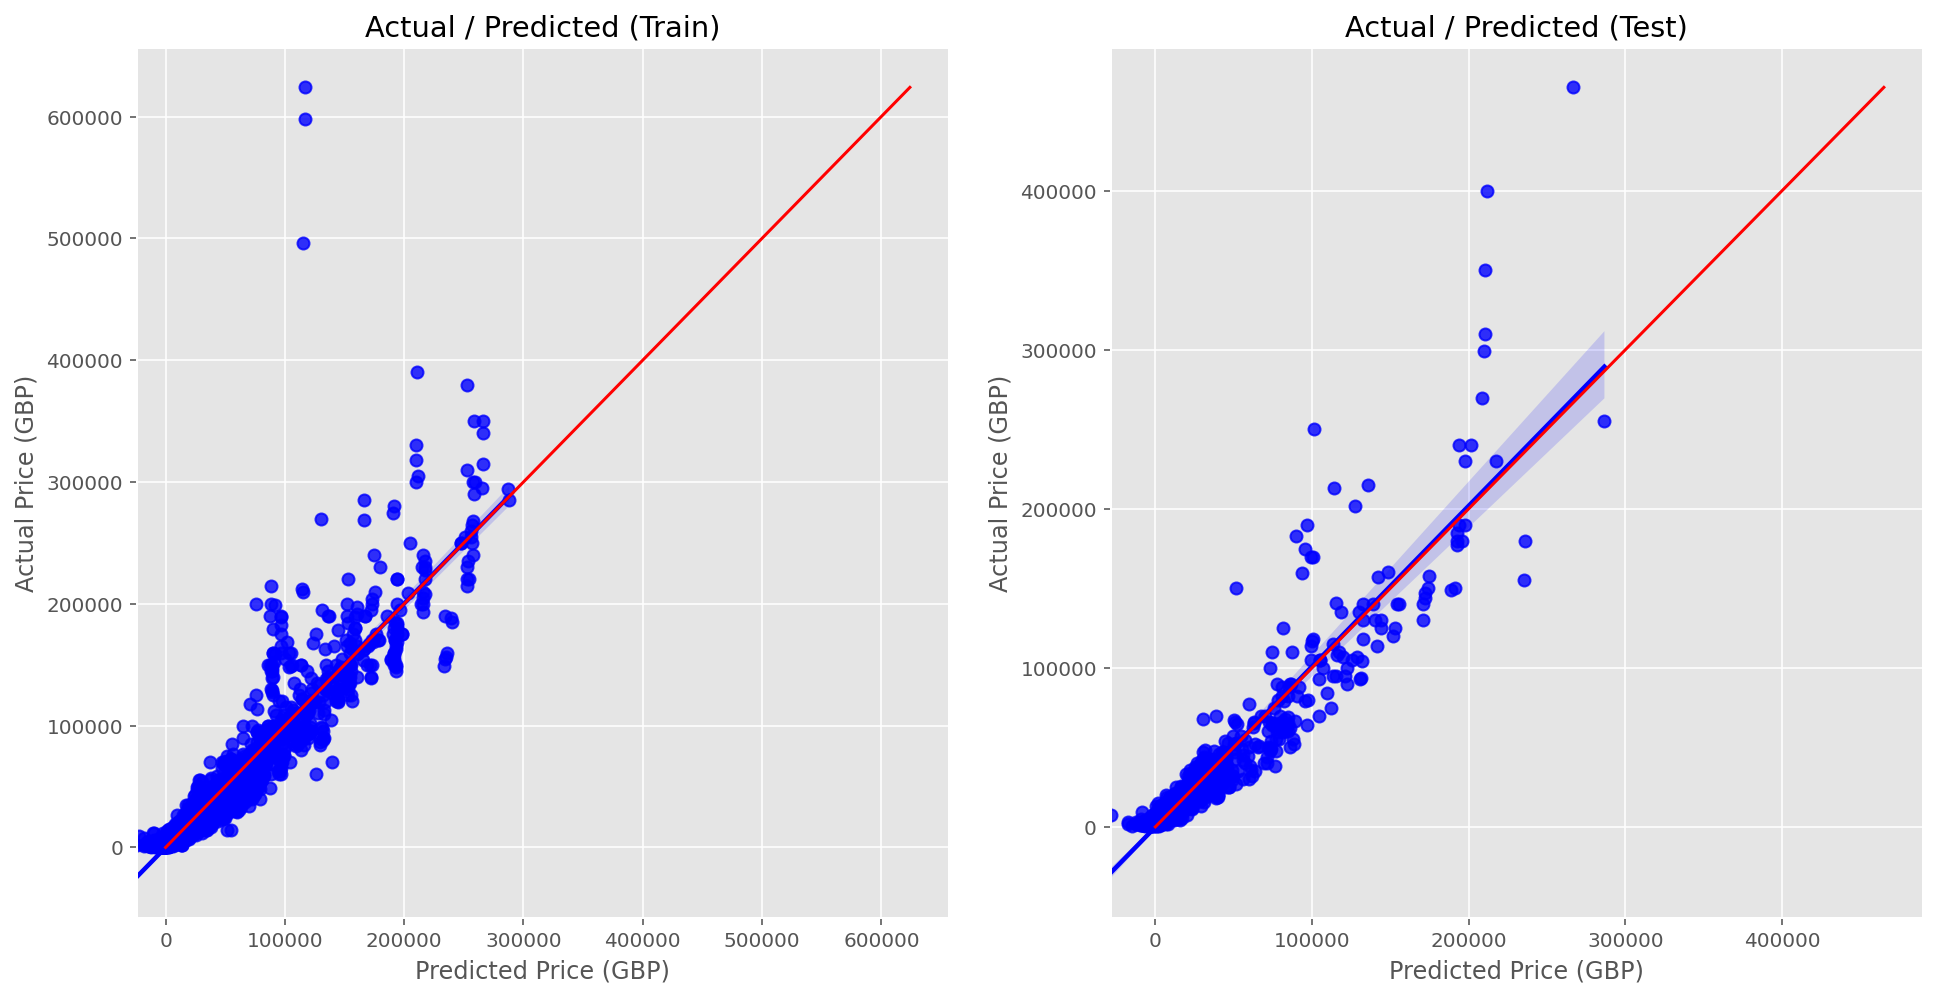

Distribution of residuals:


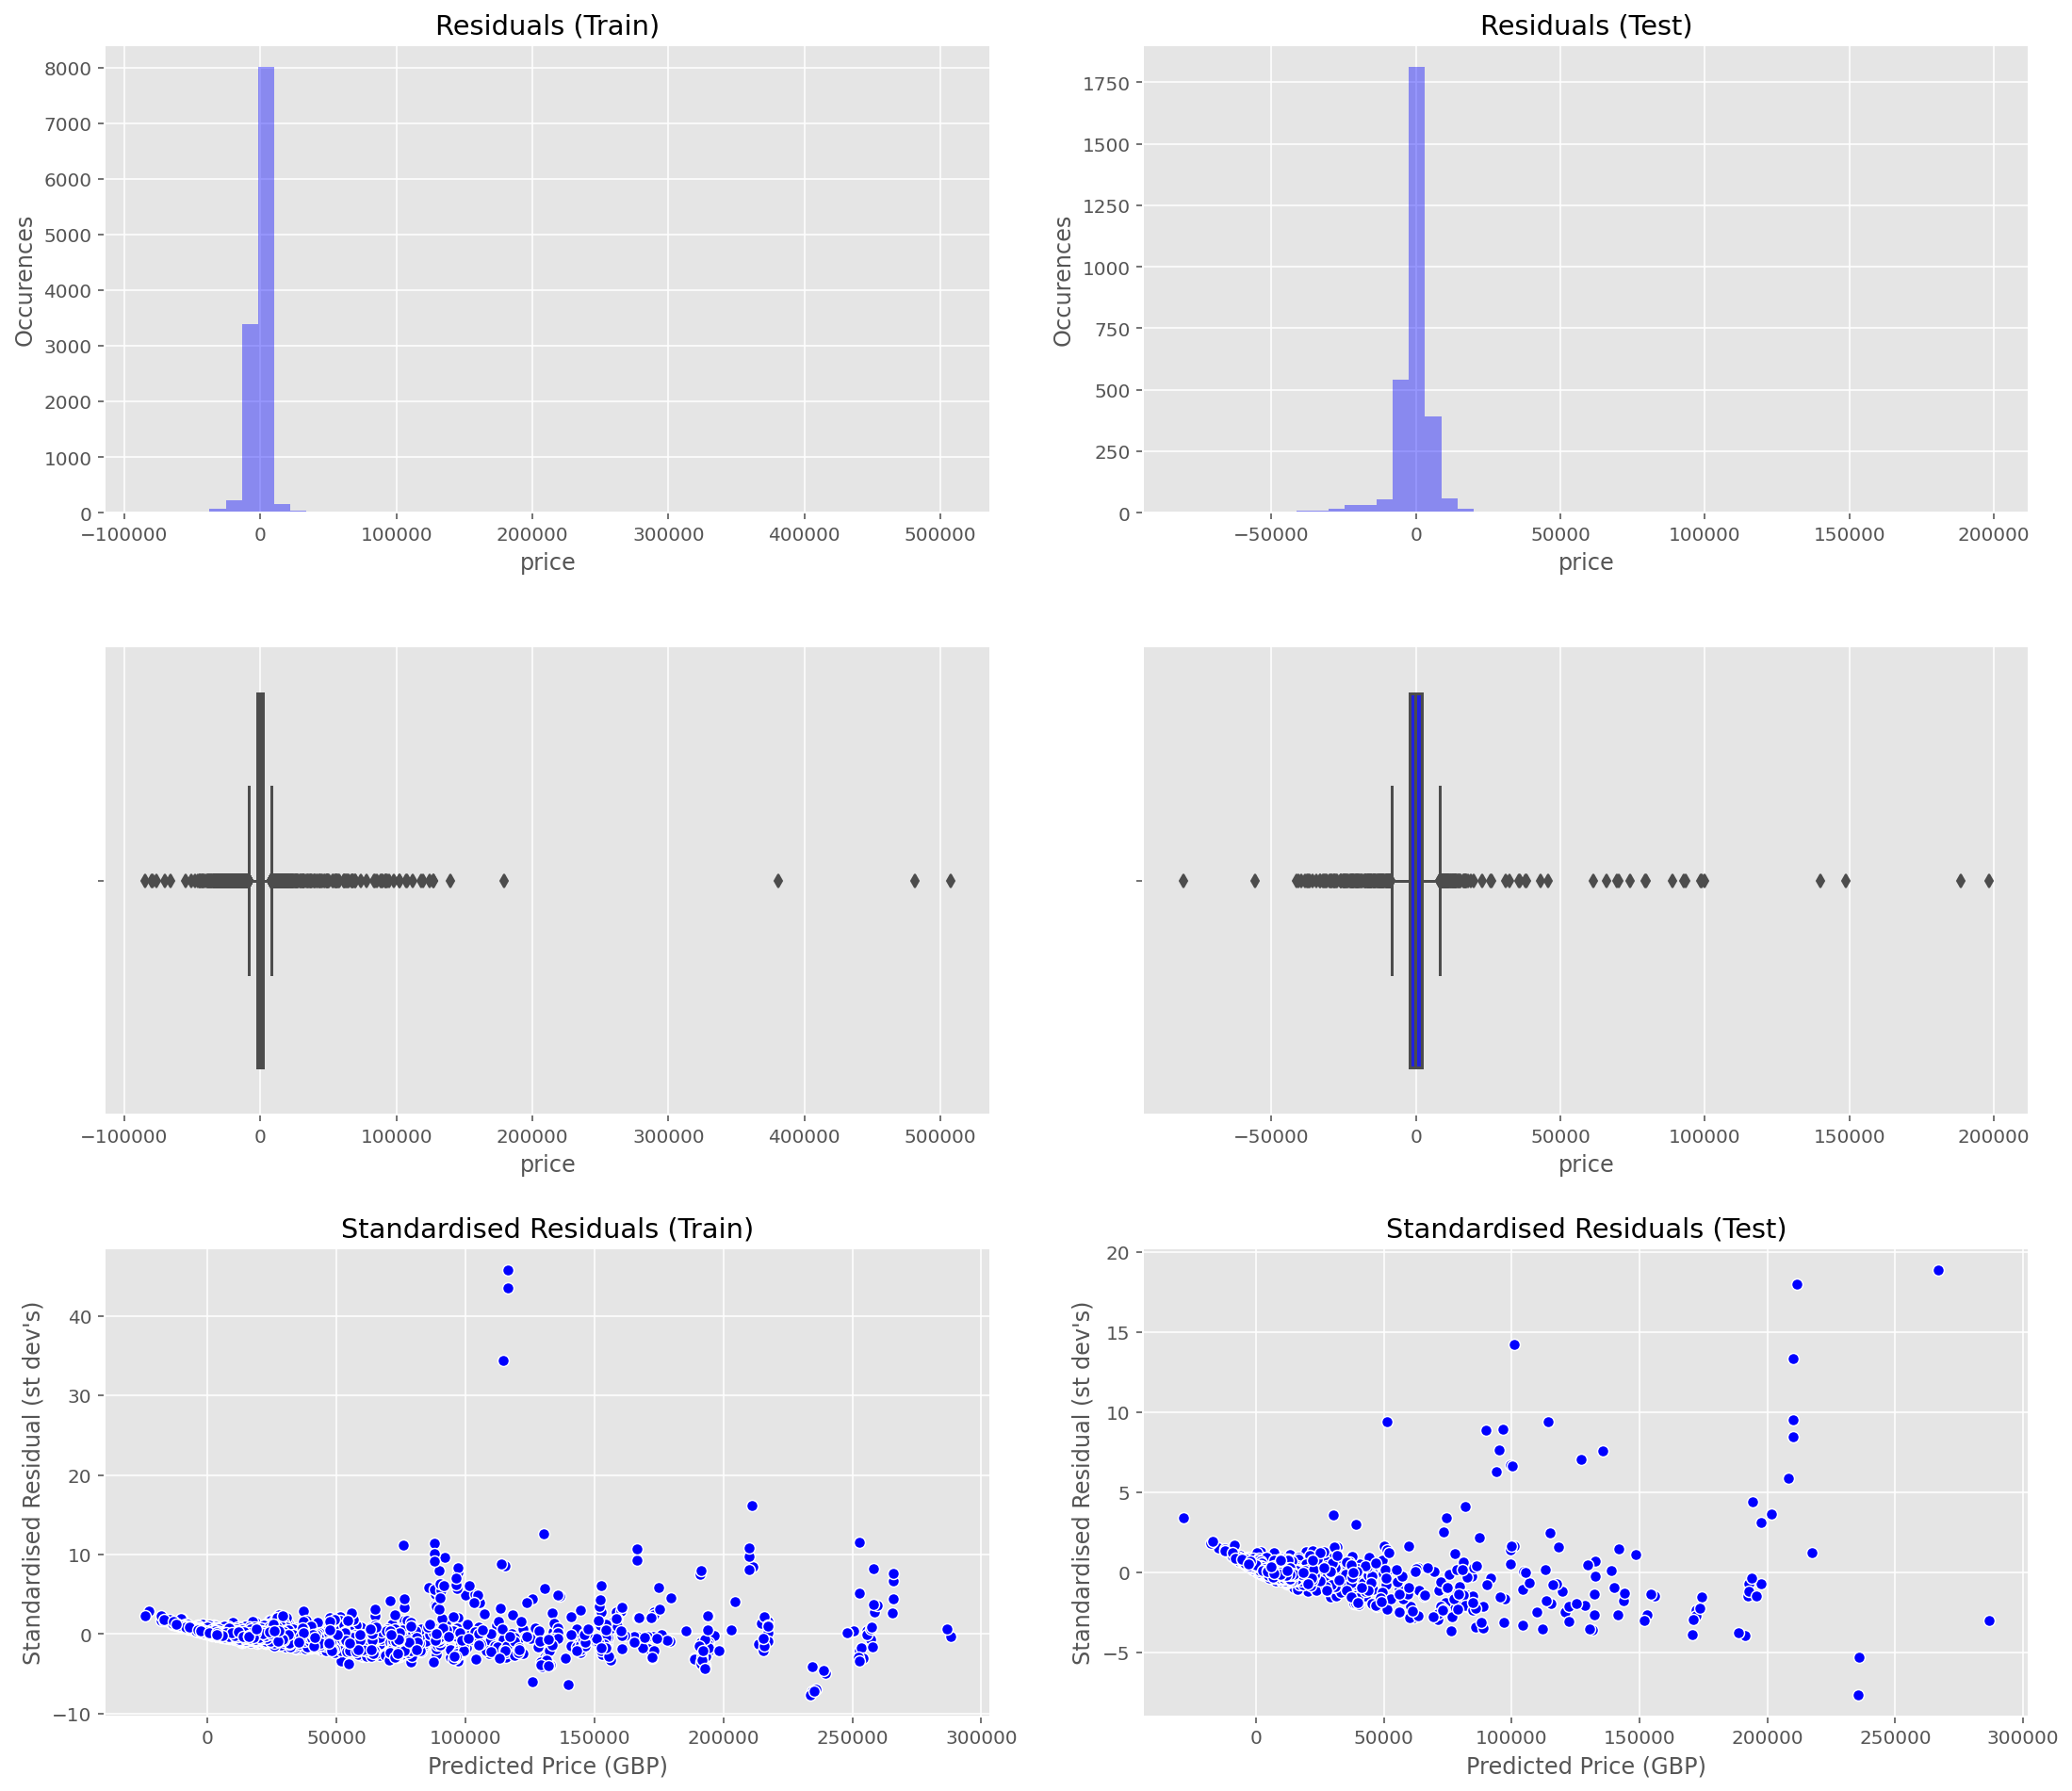

Coefficients:


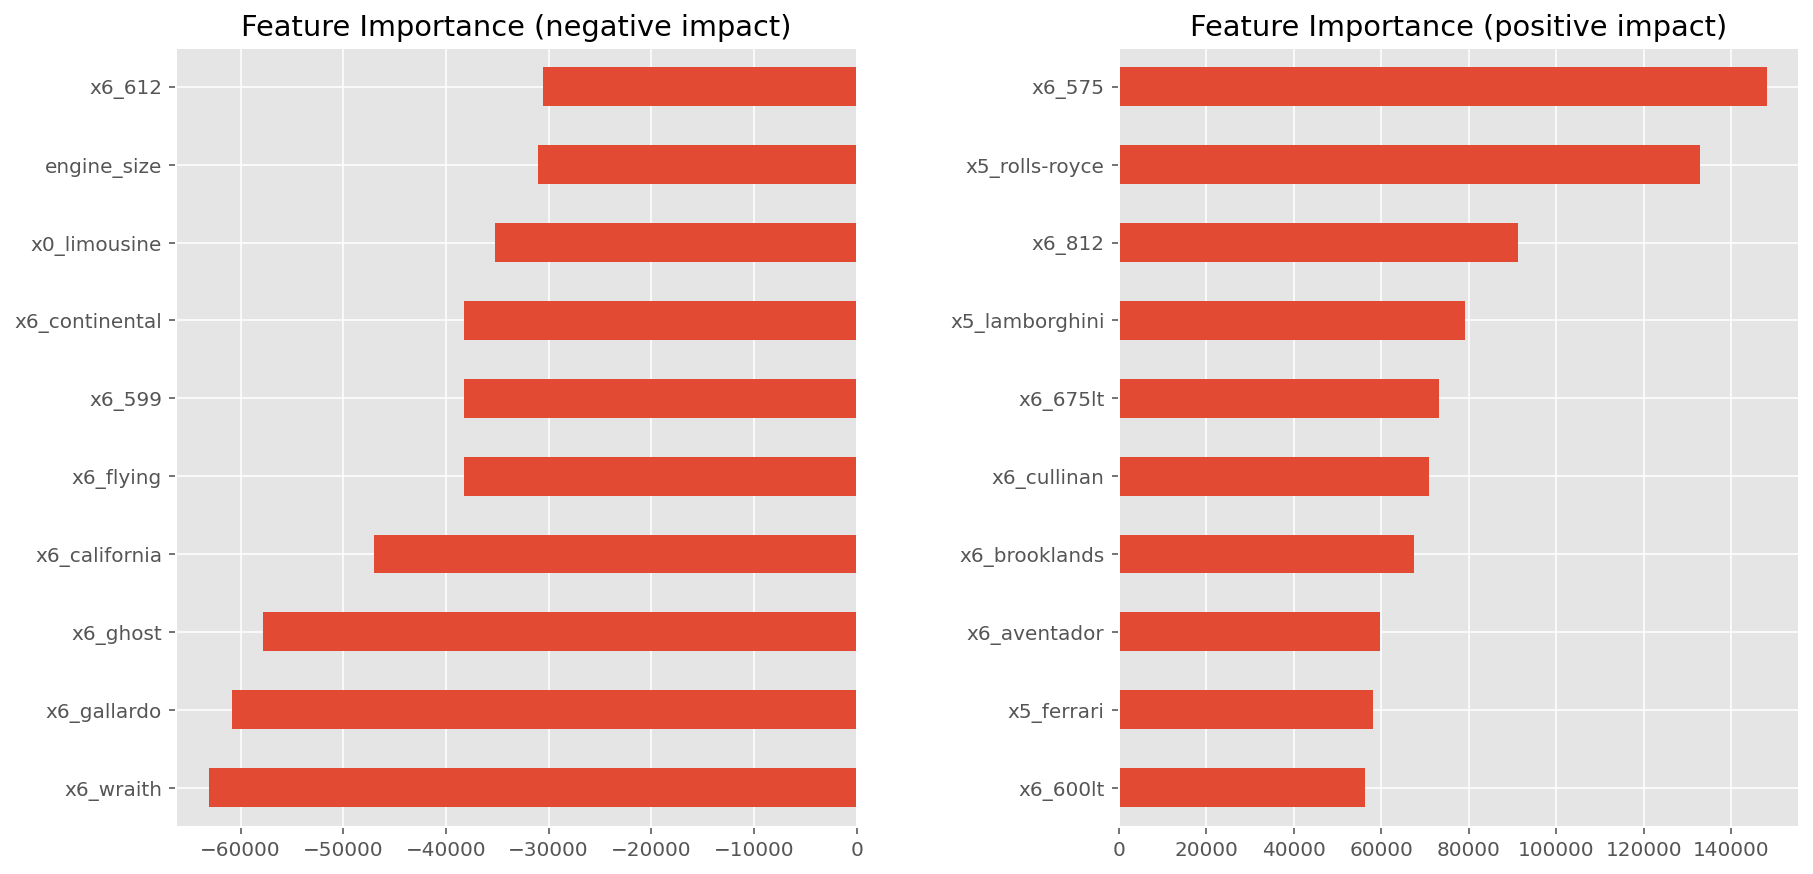

In [16]:
# LassoCV(); all features_cont, remove body and model from features_cat
features_cont = ['year', 'mileage', 'engine_size', 'horsepower', 'bhp_per_litre']
features_cat = ['body', 'transmission', 'fuel', 'ulez', 'seller_type', 'make', 'model']
# features_cat.remove('price') # remove target variable
# features_cat.remove('body')
# features_cat.remove('model')
print('cont features: ', features_cont)
print('cat features:  ', features_cat)
print()

# fit pipe
pipe = pipe_construct(features_cont, features_cat, LassoCV(alphas=np.logspace(-4,4,10), cv=5, 
                                                           n_jobs=-1, max_iter=100000, random_state=1))
pipe.fit(X_train, y_train)
print(pipe.named_steps.model)
print()

# print scores
myfunctions.print_scores(pipe, X_train, X_test, y_train, y_test)
print()

# plots
myfunctions.plot_predictions(pipe, X_train, X_test, y_train, y_test)
myfunctions.plot_residuals(pipe, X_train, X_test, y_train, y_test)
plot_coef_pipe(pipe, X_train, X_test, y_train, y_test)